In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('final dataset.csv')

In [3]:
data = data.drop_duplicates()

In [4]:
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
x[:,5] = le.fit_transform(x[:,5])
x[:,7] = le.fit_transform(x[:,7])
x[:,12] = le.fit_transform(x[:,12])
x[:,13] = le.fit_transform(x[:,13])
y = le.fit_transform(y)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x= scaler.fit_transform(x)

/home/turjoy/anaconda3/envs/Arafat/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
     x, y, test_size = 0.2, random_state = 100) 

In [8]:
from sklearn.cluster import KMeans

In [9]:
kmeans = KMeans(n_clusters=5, random_state=100)
x_train_kmean = kmeans.fit_transform(x_train) 
x_test_kmean = kmeans.transform(x_test) 

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.recurrent import SimpleRNN
from keras.layers.recurrent import LSTM 
from keras.optimizers import Adam,RMSprop
from keras.utils import np_utils
from keras.layers import Activation

Using TensorFlow backend.


In [11]:
y_train_nn = np_utils.to_categorical(y_train, 5)
y_test_nn = np_utils.to_categorical(y_test, 5)

In [12]:
x_train_nn = np.reshape(x_train_kmean, (x_train_kmean.shape[0], 1, x_train_kmean.shape[1]))
x_test_nn = np.reshape(x_test_kmean, (x_test_kmean.shape[0], 1, x_test_kmean.shape[1]))

In [13]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(32, input_shape = (1,5), return_sequences=True, kernel_initializer='uniform', activation='tanh'))
rnn_model.add(Dropout(0.4))
rnn_model.add(SimpleRNN(32,activation='tanh'))
rnn_model.add(Dropout(0.4))
rnn_model.add(Dense(units = 5,activation='softmax'))
rnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False), metrics=['accuracy'])
print(rnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1, 32)             1216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 3,461
Trainable params: 3,461
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
rnn_model.fit(x_train_nn, y_train_nn, validation_data = (x_test_nn, y_test_nn), epochs = 5, batch_size = 50)

Train on 838860 samples, validate on 209715 samples
Epoch 1/5
838860/838860 [==============================] - 122s 145us/step - loss: 0.1260 - acc: 0.9772 - val_loss: 0.1016 - val_acc: 0.9803
Epoch 2/5
838860/838860 [==============================] - 124s 148us/step - loss: 0.1082 - acc: 0.9797 - val_loss: 0.0959 - val_acc: 0.9813
Epoch 3/5
838860/838860 [==============================] - 125s 149us/step - loss: 0.1047 - acc: 0.9803 - val_loss: 0.0932 - val_acc: 0.9824
Epoch 4/5
838860/838860 [==============================] - 118s 141us/step - loss: 0.1030 - acc: 0.9807 - val_loss: 0.0946 - val_acc: 0.9826
Epoch 5/5
838860/838860 [==============================] - 141s 168us/step - loss: 0.1018 - acc: 0.9808 - val_loss: 0.0920 - val_acc: 0.9822


In [15]:
metrics = rnn_model.evaluate(x_test_nn, y_test_nn, verbose=1)
print("Metrics(Test loss & Test Accuracy): ")
print(metrics)

209715/209715 [==============================] - 14s 67us/step
Metrics(Test loss & Test Accuracy): 
[0.09201630861522951, 0.9821710416517655]


In [16]:
import matplotlib.pyplot as plt
import itertools

In [18]:
from sklearn.metrics import confusion_matrix
y_expect = y_test_nn
y_expect = np.argmax(y_expect, axis=1)
y_predict = rnn_model.predict(x_test_nn)
y_predict = np.argmax(y_predict, axis=1)
cm = confusion_matrix(y_expect, y_predict)

In [19]:
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

In [20]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

In [21]:
class_names = ['Normal','UDP-Flood','Smurf','SIDDOS','HTTP-FLOOD']

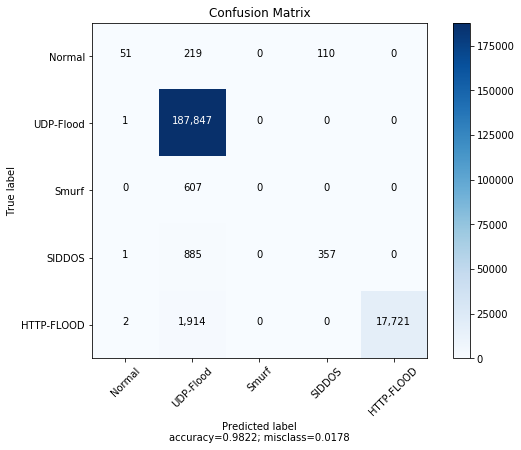

In [33]:
from sklearn.metrics import confusion_matrix
y_expect = y_test_nn
y_expect = np.argmax(y_expect, axis=1)
y_predict = rnn_model.predict(x_test_nn)
y_predict = np.argmax(y_predict, axis=1)
cm = confusion_matrix(y_expect, y_predict)
plot_confusion_matrix(cm           = cm , 
                      normalize    = False,
                      target_names = class_names,
                      title        = "Confusion Matrix")
plt.show()

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_expect,y_predict))

              precision    recall  f1-score   support

           0       0.93      0.13      0.23       380
           1       0.98      1.00      0.99    187848
           2       0.00      0.00      0.00       607
           3       0.76      0.29      0.42      1243
           4       1.00      0.90      0.95     19637

   micro avg       0.98      0.98      0.98    209715
   macro avg       0.73      0.46      0.52    209715
weighted avg       0.98      0.98      0.98    209715



/home/turjoy/anaconda3/envs/Arafat/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


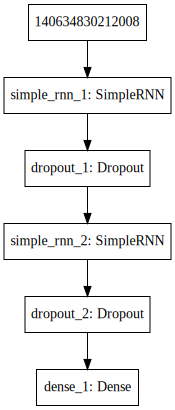

In [35]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(rnn_model).create(prog='dot', format='svg'))

In [36]:
from keras.utils import plot_model
plot_model(rnn_model,show_shapes=True,rankdir='TB',to_file='kmeanRnn.png')

In [37]:
y_train_lstm = np_utils.to_categorical(y_train, 5)
y_test_lstm = np_utils.to_categorical(y_test, 5)

In [38]:
data_dim = 5
timesteps = 1

model = Sequential()
model.add(LSTM(30, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 30
model.add(LSTM(30, return_sequences=True))  # returns a sequence of vectors of dimension 30
model.add(LSTM(30))  # return a single vector of dimension 30
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 30)             4320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 30)             7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 155       
Total params: 19,115
Trainable params: 19,115
Non-trainable params: 0
_________________________________________________________________


In [39]:
x_train_lstm = np.reshape(x_train_kmean, (x_train_kmean.shape[0], 1, x_train_kmean.shape[1]))
x_test_lstm = np.reshape(x_test_kmean, (x_test_kmean.shape[0], 1, x_test_kmean.shape[1]))

In [40]:
model.fit(x_train_lstm, y_train_lstm,validation_data = (x_test_lstm, y_test_lstm), batch_size = 50, epochs = 5, verbose = 1)

Train on 838860 samples, validate on 209715 samples
Epoch 1/5
838860/838860 [==============================] - 289s 345us/step - loss: 0.1030 - acc: 0.9792 - val_loss: 0.0858 - val_acc: 0.9829
Epoch 2/5
838860/838860 [==============================] - 276s 329us/step - loss: 0.0876 - acc: 0.9829 - val_loss: 0.0855 - val_acc: 0.9831
Epoch 3/5
838860/838860 [==============================] - 286s 340us/step - loss: 0.0871 - acc: 0.9835 - val_loss: 0.0842 - val_acc: 0.9842
Epoch 4/5
838860/838860 [==============================] - 316s 377us/step - loss: 0.0867 - acc: 0.9839 - val_loss: 0.0863 - val_acc: 0.9853
Epoch 5/5
838860/838860 [==============================] - 325s 387us/step - loss: 0.0871 - acc: 0.9841 - val_loss: 0.0857 - val_acc: 0.9846


In [41]:
metrics = model.evaluate(x_test_lstm, y_test_lstm, verbose=1)
print("Metrics(Test loss & Test Accuracy): ")
print(metrics)

209715/209715 [==============================] - 23s 111us/step
Metrics(Test loss & Test Accuracy): 
[0.08572291525330067, 0.9845504613403905]


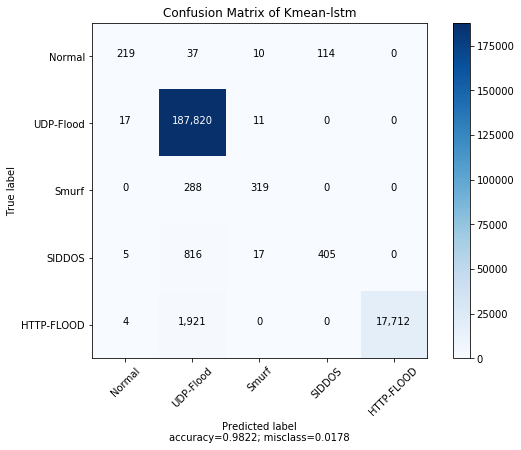

In [42]:
from sklearn.metrics import confusion_matrix
y_expect = y_test_lstm
y_expect = np.argmax(y_expect, axis=1)
y_predict = model.predict(x_test_lstm)
y_predict = np.argmax(y_predict, axis=1)
cm = confusion_matrix(y_expect, y_predict)
plot_confusion_matrix(cm           = cm , 
                      normalize    = False,
                      target_names = class_names,
                      title        = "Confusion Matrix of Kmean-lstm")
plt.show()

In [43]:
print(classification_report(y_expect,y_predict))

              precision    recall  f1-score   support

           0       0.89      0.58      0.70       380
           1       0.98      1.00      0.99    187848
           2       0.89      0.53      0.66       607
           3       0.78      0.33      0.46      1243
           4       1.00      0.90      0.95     19637

   micro avg       0.98      0.98      0.98    209715
   macro avg       0.91      0.67      0.75    209715
weighted avg       0.98      0.98      0.98    209715



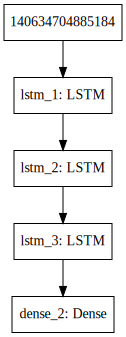

In [44]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [45]:
from keras.utils import plot_model
plot_model(model,show_shapes=True,rankdir='TB',to_file='kmeanLstm.png')